In [1]:
from models import get_model
import torch

import torch.nn as nn

C:\Users\Achyut Burlakoti\AppData\Roaming\Python\Python39\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
model = get_model('resnet')

model.to(torch.device('cuda'))

C:\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNetFeatureModel(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv

In [3]:
path = './models/res-net.pt'

checkpoint = torch.load(path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [4]:
from dataset import ImageDataset

In [5]:
BATCH_SIZE = 16

In [6]:
test_dataset = ImageDataset(status="test")

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

### Let's calculate the precision and recall

In [7]:
from collections import defaultdict

In [8]:
# Create dictionary to store TP, FP, TN, FN counts for each class
class_counts = defaultdict(lambda: defaultdict(int))

with torch.no_grad():
    y_pred = []
    y_true = []
    for image, label in test_dataloader:
        
        image = image.to(torch.device('cuda'))
        label = label.to(torch.device('cuda'))
        
        output = model(image)
        
        _, predicted_labels = torch.max(output.data, 1)
        
        for i in range(len(predicted_labels)):
            pred = predicted_labels[i].item()
            true = label[i].item()
            
            if true == 1:
                if pred == 1:
                    class_counts[0]['TP'] += 1
                else :
                    class_counts[0]['FN'] += 1
            else :
                if pred == 1:
                    class_counts[0]['FP'] += 1
                else :
                    class_counts[0]['TN'] += 1
                    
            y_pred.append(pred)
            y_true.append(true)
    
    tp = class_counts[0]['TP']
    fp = class_counts[0]['FP']
    fn = class_counts[0]['FN']
    tn = class_counts[0]['TN']
        
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall    = tp / (tp + fn) if (tp + fn) > 0 else 0

In [9]:
precision, recall

(0.6020790020790021, 0.905)

In [10]:
class_counts

defaultdict(<function __main__.<lambda>()>,
            {0: defaultdict(int,
                         {'FP': 957, 'TP': 1448, 'FN': 152, 'TN': 643})})

In [11]:
import matplotlib.pyplot as plt

In [12]:
# Create a function to plot the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


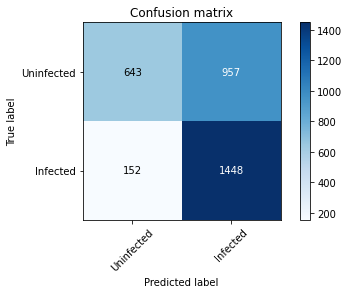

In [13]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Define class names
class_names = ["Uninfected", "Infected"]
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')